In [91]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# How many transcription units are regulated by each Sigma Factor?

Based off a SmartTable created on EcoCyc: https://ecocyc.org/group?id=biocyc13-20082-3697684655

In [70]:
tu = pd.read_table('./tu-sigma.xls')

In [105]:
names = pd.read_csv('./sigma-names.csv')
names['EcoCyc'] = names['Gene'].str.upper() + "-MONOMER"
names.ix[6,'EcoCyc'] = 'PD00440' # FecI
names.ix[4,'EcoCyc'] = 'EG11355-MONOMER' # FliA

In [106]:
names

,SigmaFactor,Number,Gene,Description,EcoCyc
0,Sigma70,70,RpoD,Housekeeping,RPOD-MONOMER
1,Sigma54,54,RpoN,Nitrogen limitation,RPON-MONOMER
2,Sigma38,38,RpoS,Stationary Phase,RPOS-MONOMER
3,Sigma32,32,RpoH,Heat shock,RPOH-MONOMER
4,Sigma28,28,RpoF,Flagella,EG11355-MONOMER
5,Sigma24,23,RpoE,Extracytoplasmic/extreme heat stress,RPOE-MONOMER
6,Sigma19,19,FecI,Iron transport,PD00440


Reorganise so we get duplicated records where a TU is regulated by multiple sigma factors

In [107]:
sigmas = tu['Binds-Sigma-Factor'].str.split(' // ').apply(pd.Series, 1).stack()
sigmas.index = sigmas.index.droplevel(-1)
sigmas.name = 'Sigma-Factor'
tusigma = tu.join(sigmas)
# tusigma['Sigma-Factor'] = tusigma['Sigma-Factor'].fillna('None') # Show up non-regulated tus

Basic stats

NB: 

* EG11355 = Flagella / fliA / sigma 28
* PD00440 = Iron / fecI / sigma 19

In [72]:
len(tu['Transcription-Units'].unique())

3556

In [108]:
pd.merge(names,tusigma, left_on='EcoCyc', right_on='Sigma-Factor').groupby('SigmaFactor').count()['Transcription-Units']

SigmaFactor
Sigma19       1
Sigma24      82
Sigma28      34
Sigma32      97
Sigma38     218
Sigma54      53
Sigma70    1066
Name: Transcription-Units, dtype: int64

We have a bunch of transcription units that are not annotated with sigmas:

In [164]:
tu['Binds-Sigma-Factor'].isnull().sum()

2124

But these could be embedded in TUs that ARE regulated by sigmas.

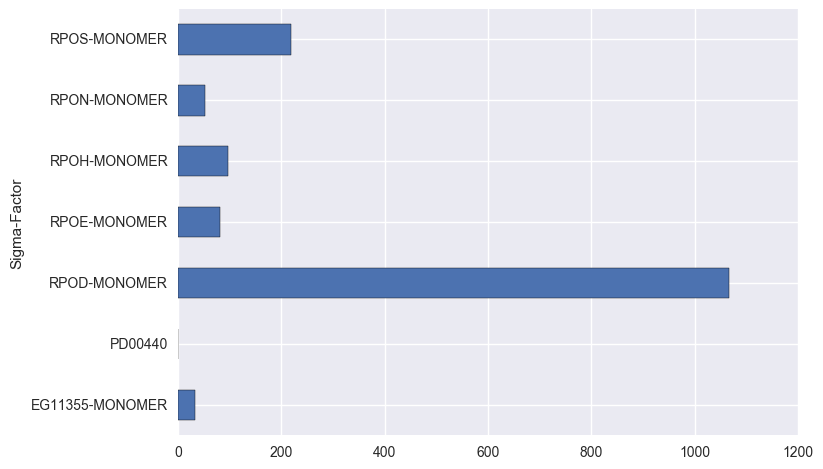

In [165]:
tusigma.groupby('Sigma-Factor').count()['Transcription-Units'].plot.barh()

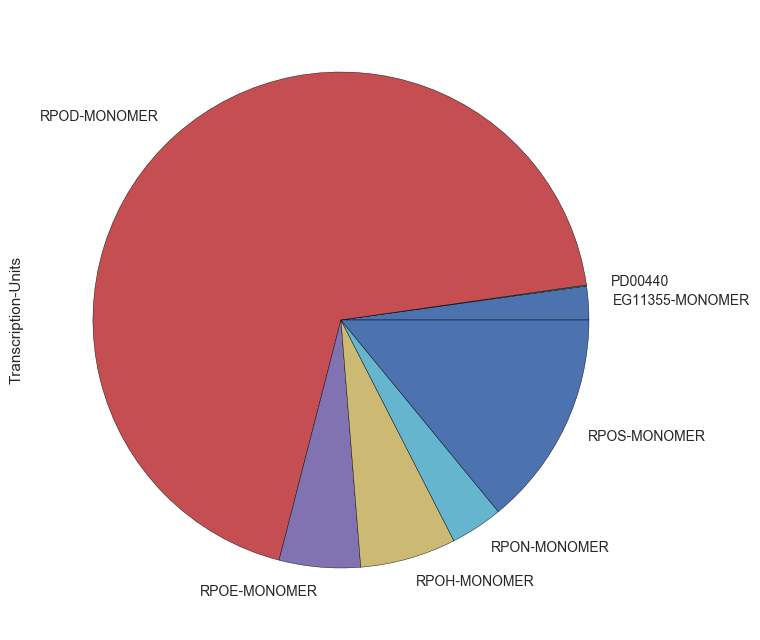

In [166]:
tusigma.groupby('Sigma-Factor').count()['Transcription-Units'].plot.pie(figsize=(8,8))

Suggests we could remove all non-RPOD transcription units: 485 promoters/units

In [183]:
tusigma[tusigma['Sigma-Factor'].notnull() & (tusigma['Sigma-Factor'] != 'RPOD-MONOMER').fillna("")].count()

Transcription-Units                                 485
Regulated-By                                         16
Transcription units - promoter of operon            485
PROMOTER-BOXES                                      485
Promoters - binding sites that regulate promoter    230
Binds-Sigma-Factor                                  485
Sigma-Factor                                        485
dtype: int64

PythonCyc:

# RegulonDB Analysis

In [3]:
tu = pd.read_table(
    './tu-start.txt', 
    comment='#', 
    header=None, 
    names=['Operon', 'TU', 'Promoter', 'TSS', 'Strand', 'FirstGene', 'LastGene', 'Terminator', 'UTR', '5pUTR', '5pUTRseq', '3pUTR', '3pUTRseq'])

tu_sigma = pd.read_table(
    './network_sigma_tu.txt',
    comment='#',
    index_col=False,
    header=None,
    names=['SigmaFactor', 'TUFull', 'Effect', 'Evidence', 'Strength'])

In [4]:
tu

,Operon,TU,Promoter,TSS,Strand,FirstGene,LastGene,Terminator,UTR,5pUTR,5pUTRseq,3pUTR,3pUTRseq
0,thrLABC,thrLABC,thrLp,148.0,forward,"thrL(190,255)","thrC(3734,5020)",NaN,148-5020,148-190,ATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCA,NaN,NaN
1,thrLABC,thrL,thrLp,148.0,forward,"thrL(190,255)","thrL(190,255)","rho-independent(274,310)",148-310,148-190,ATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCA,255-310,ACGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGACAGTGCGGG...
2,talB,talB,talBp,8191.0,forward,"talB(8238,9191)","talB(8238,9191)","rho-independent(9199,9226)",8191-9226,8191-8238,AGACCGGTTACATCCCCCTAACAAGCTGTTTAAAGAGAAATACTATCA,9191-9226,ATCATTCTTAGCGTGACCGGGAAGTCGGTCACGCTA
3,htgA,htgA,htgAp2,10643.0,forward,"htgA(10830,11315)","htgA(10830,11315)",NaN,10643-11315,10643-10830,TCAGACCTGAGTGGCGCTAACCATCCGGCGCAGGCAGGCGATTTGC...,NaN,NaN
4,htgA,htgA,htgAp1,10644.0,forward,"htgA(10830,11315)","htgA(10830,11315)",NaN,10644-11315,10644-10830,CAGACCTGAGTGGCGCTAACCATCCGGCGCAGGCAGGCGATTTGCA...,NaN,NaN
5,dnaK-tpke11-dnaJ,dnaK-tpke11-dnaJ,dnaKp1,12048.0,forward,"dnaK(12163,14079)","dnaJ(14168,15298)",NaN,12048-15298,12048-12163,AACCGCAGTGAGTGAGTCTGCAAAAAAATGAAATTGGGCAGTTGAA...,NaN,NaN
6,dnaK-tpke11-dnaJ,dnaK-tpke11-dnaJ,dnaKp2,12123.0,forward,"dnaK(12163,14079)","dnaJ(14168,15298)",NaN,12123-15298,12123-12163,ACAACCACATGATGACCGAATATATAGTGGAGACGTTTAGA,NaN,NaN
7,dnaK-tpke11-dnaJ,dnaK-tpke11-dnaJ,dnaKp3,12144.0,forward,"dnaK(12163,14079)","dnaJ(14168,15298)",NaN,12144-15298,12144-12163,ATATAGTGGAGACGTTTAGA,NaN,NaN
8,nhaAR,nhaAR,nhaAp2,17317.0,forward,"nhaA(17489,18655)","nhaR(18715,19620)",NaN,17317-19620,17317-17489,GGTCACTCGTGAGCGCTTACAGCCGTCAAAAACGCATCTCACCGCT...,NaN,NaN
9,nhaAR,nhaAR,nhaAp1,17458.0,forward,"nhaA(17489,18655)","nhaR(18715,19620)",NaN,17458-19620,17458-17489,ACGATCTATTCACCTGAAAGAGAAATAAAAAG,NaN,NaN


In [5]:
tu_sigma[['TU','TUReg']] = tu_sigma['TUFull'].str.extract(r'(\w+)\[(\w+)\]')

/Users/anton/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [6]:
tu_m = pd.merge(tu, tu_sigma, on='TU')
tu_m = tu_m.dropna(subset=['TSS'])

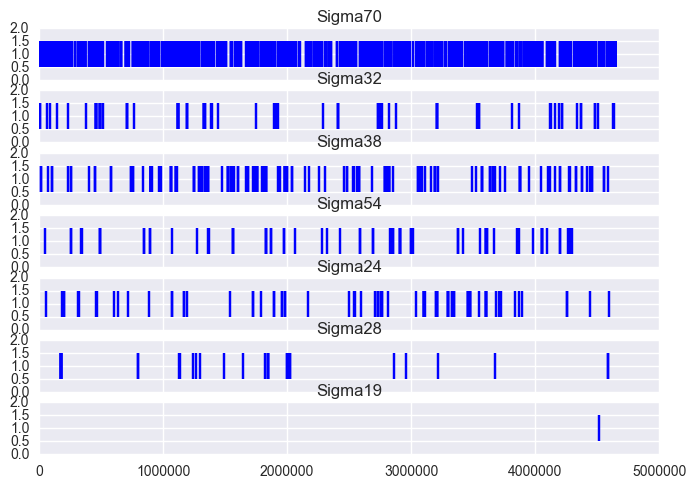

In [7]:
MG_LENGTH = 4641652

sigs = tu_m['SigmaFactor'].unique()
fig, ax = plt.subplots(len(sigs), sharex=True)

for i, sig in enumerate(sigs):
    ax[i].set_title(sig)
    ax[i].eventplot(tu_m.ix[tu_m['SigmaFactor'] == sig, 'TSS'], orientation='horizontal')

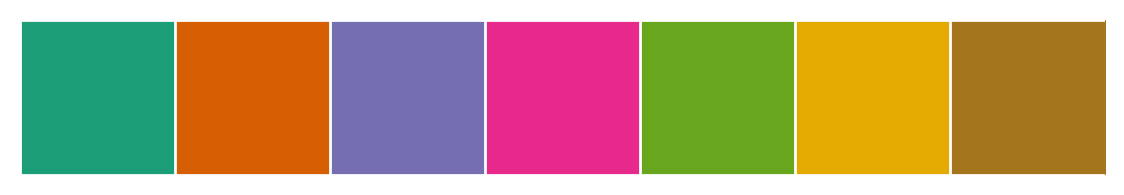

In [92]:

sns.palplot(sns.color_palette('Dark2', 7))

/Users/anton/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


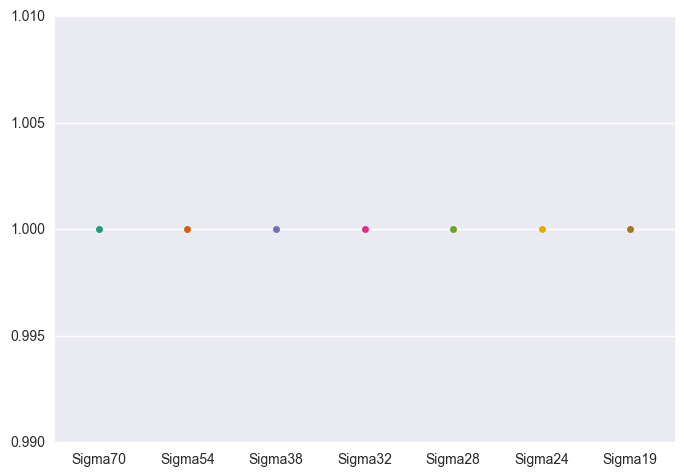

In [90]:
sns.stripplot(sorted(tu_m['SigmaFactor'].unique(), reverse=True), np.ones((7,)), palette='Dark2')
plt.legend()

In [38]:
rev(sorted(tu_m['SigmaFactor'].unique()))

NameError: name 'rev' is not defined

(0, 4641652)

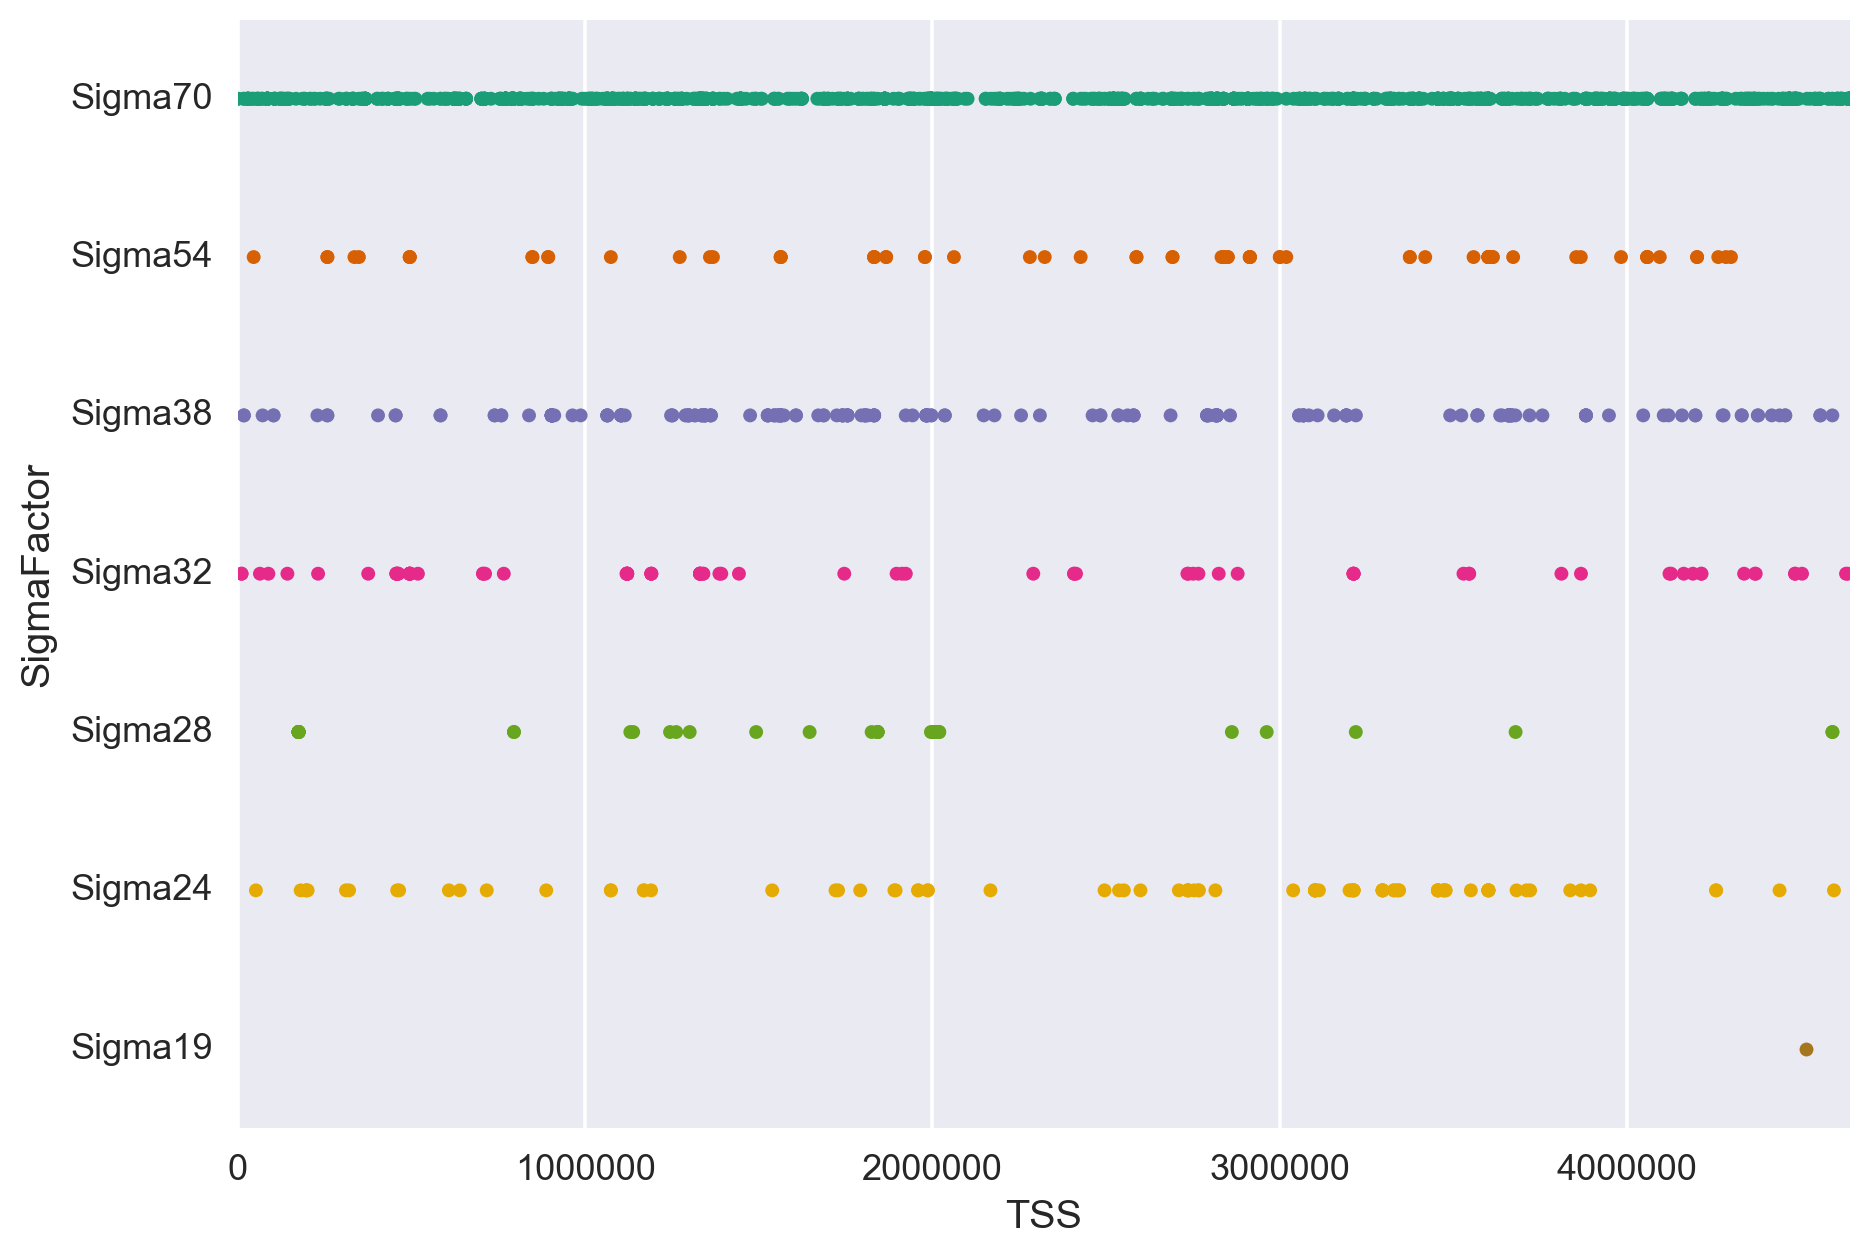

In [98]:
# plt.figure(figsize=(15,15))
sns.set_context('talk')
sns.stripplot(x='TSS', y='SigmaFactor', data=tu_m, palette=sns.color_palette('Dark2', 7), order=sorted(tu_m['SigmaFactor'].unique(), reverse=True))
plt.xlim((0, MG_LENGTH))

TypeError: unsupported operand type(s) for /: 'str' and 'float'

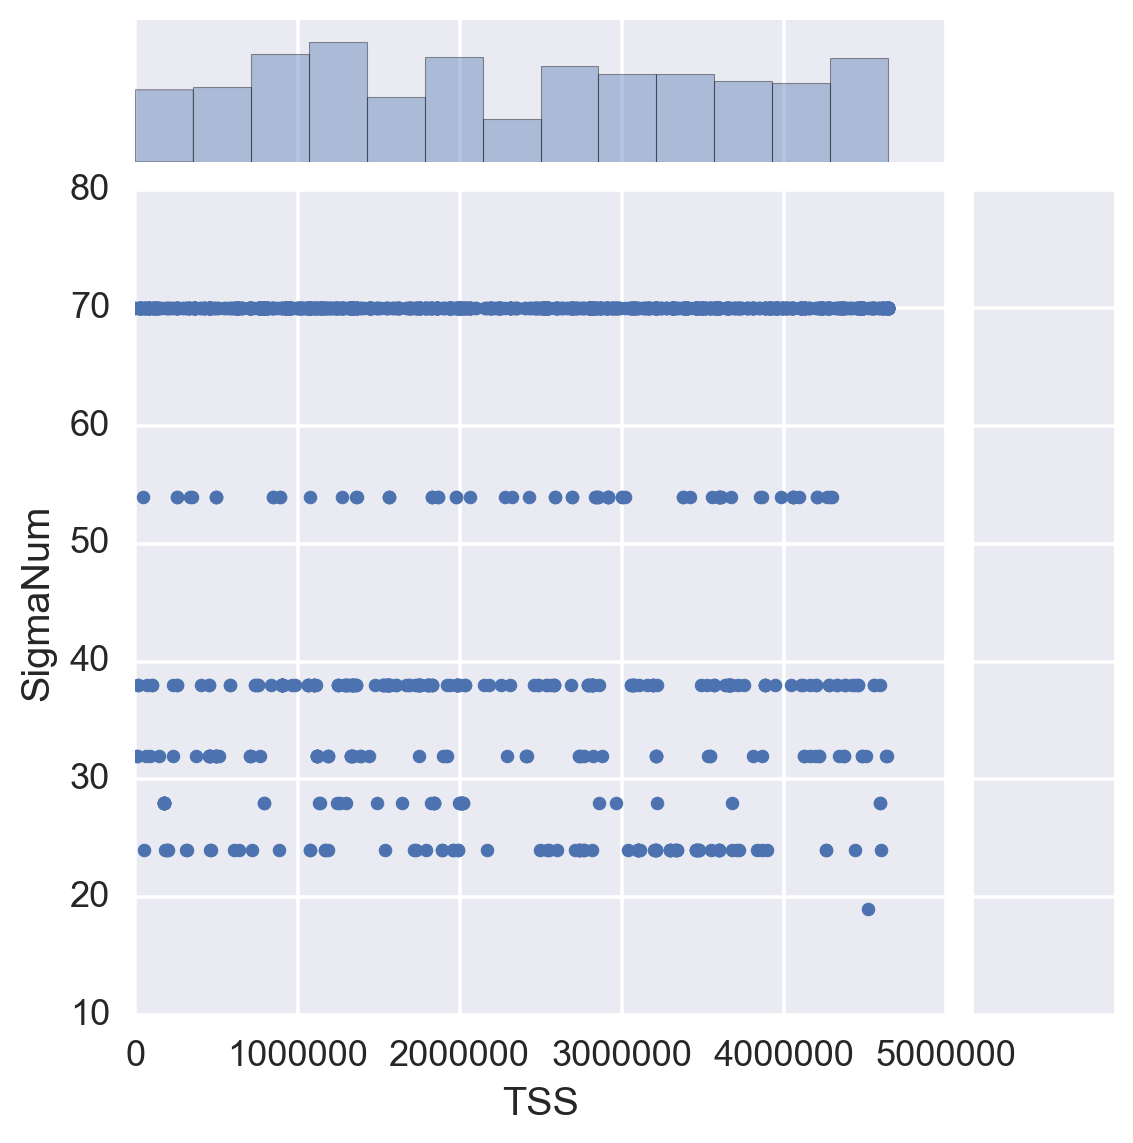

In [102]:
sns.jointplot(x='TSS', y='SigmaNum', data=tu_m)#, palette=sns.color_palette('Dark2', 7), order=sorted(tu_m['SigmaFactor'].unique(), reverse=True))
# plt.xlim((0, MG_LENGTH))

In [41]:
tu_m['End'] = tu_m['LastGene'].str.extract(r'.*\(\d+,(\d+)\)', expand=False)
tu_m['End'] = tu_m['UTR'].str.extract(r'\d+-(\d+)', expand=False)

In [42]:
tu_m.head()

,Operon,TU,Promoter,TSS,Strand,FirstGene,LastGene,Terminator,UTR,5pUTR,...,3pUTRseq,SigmaFactor,TUFull,Effect,Evidence,Strength,TUReg,End,Chromosome,Heat
0,thrLABC,thrLABC,thrLp,148,forward,"thrL(190,255)","thrC(3734,5020)",NaN,148-5020,148-190,...,NaN,Sigma70,thrLABC[thrLp],+,"[IMP, RS-EPT-CBR, TIM]",Weak,thrLp,5020,ec1,1
1,thrLABC,thrL,thrLp,148,forward,"thrL(190,255)","thrL(190,255)","rho-independent(274,310)",148-310,148-190,...,ACGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGACAGTGCGGG...,Sigma70,thrL[thrLp],+,"[IMP, RS-EPT-CBR, TIM]",Weak,thrLp,310,ec1,1
2,htgA,htgA,htgAp2,10643,forward,"htgA(10830,11315)","htgA(10830,11315)",NaN,10643-11315,10643-10830,...,NaN,Sigma32,htgA[htgAp1],+,"[HIPP, TIM]",Weak,htgAp1,11315,ec1,1
3,htgA,htgA,htgAp1,10644,forward,"htgA(10830,11315)","htgA(10830,11315)",NaN,10644-11315,10644-10830,...,NaN,Sigma32,htgA[htgAp1],+,"[HIPP, TIM]",Weak,htgAp1,11315,ec1,1
4,nhaAR,nhaAR,nhaAp2,17317,forward,"nhaA(17489,18655)","nhaR(18715,19620)",NaN,17317-19620,17317-17489,...,NaN,Sigma38,nhaAR[nhaAp2],+,[TIM],Strong,nhaAp2,19620,ec1,1


In [13]:
tu_m['TSS'] = pd.to_numeric(tu_m['TSS'], downcast='integer')

In [11]:
tu_m['Chromosome'] = 'ec1'
tu_m['Heat'] = 1

In [43]:
for sig in sigs:
    tu_m.ix[tu_m['SigmaFactor'] == sig, ['Chromosome','TSS','End','Heat']].to_csv('./circos/sigmas/{}.txt'.format(sig), sep=' ', header=False, index=False)
#     !sed 's/^/ec1 /' {sig}.txt > ./circos/sigmas/{sig}.txt
#     !rm {sig}.txt

In [57]:
tu_m.groupby('SigmaFactor').count()['TU']

SigmaFactor
Sigma19       1
Sigma24      89
Sigma28      39
Sigma32      81
Sigma38     207
Sigma54      71
Sigma70    1489
Name: TU, dtype: int64

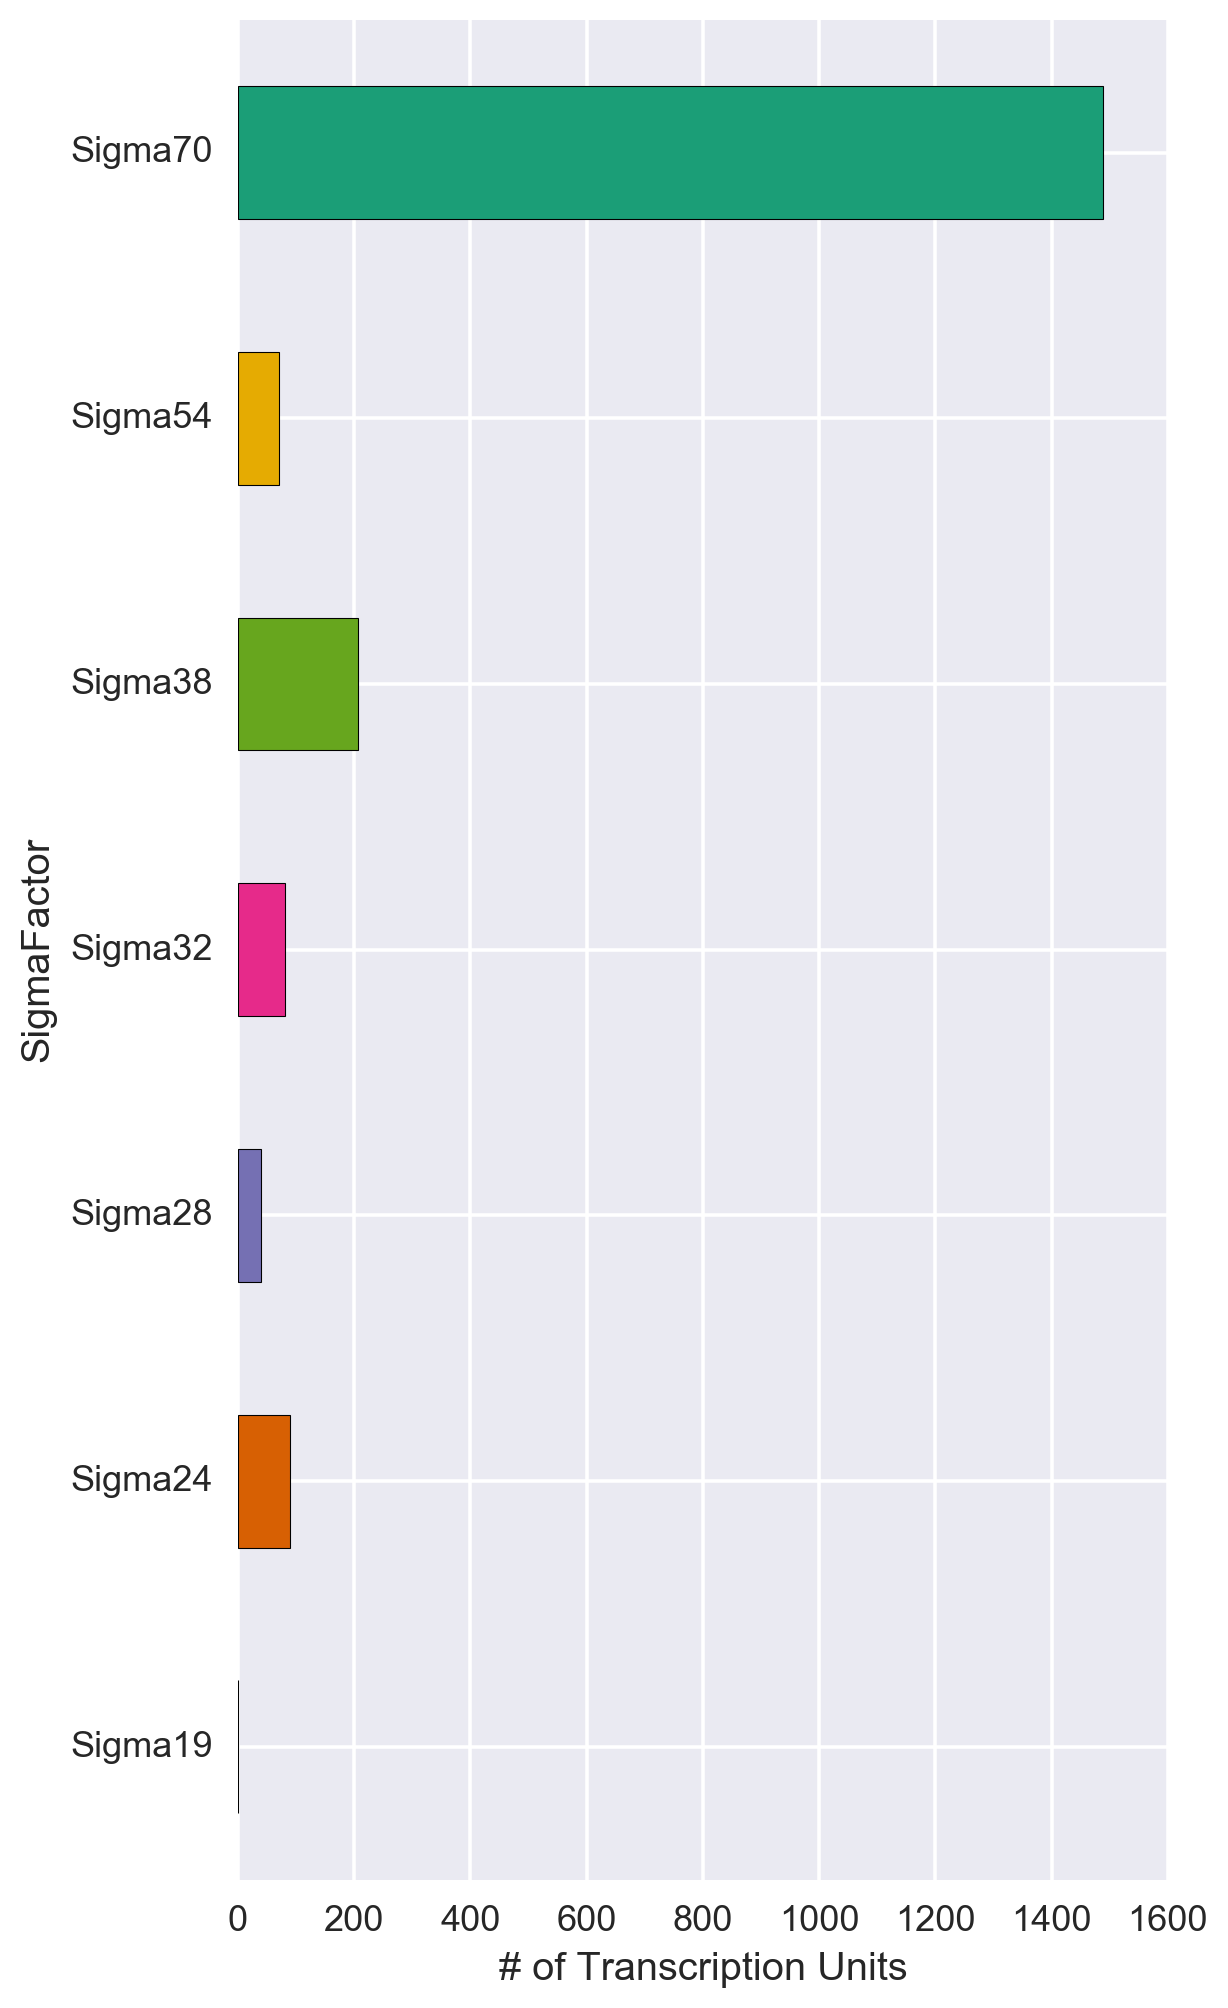

In [104]:
plt.figure(figsize=(6,12))
tu_m.groupby('SigmaFactor').count()['TU'].plot.barh(color=sns.color_palette('Dark2'))
plt.xlabel('# of Transcription Units')